In [1]:
#imports
from helper import data_loader, math_helper, k_center, plot_helper
from pyclustering.cluster.kmedians import kmedians
from fairlets.fairlets import fairlet_decomposition
import numpy as np
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt

In [2]:
loader = data_loader.data_loader('./config/dataset_config.json')
mathHelper = math_helper.math_helper(loader)
config = loader.get_config()
dataset_name = "adult"

Dataset name: adult; randomState used: 43
Amount of Male values:  32650
Amount of Female values:  16192
Amount of 0 values:  392
Amount of 1 values:  208
balance of the chosen sample: 0.5306122448979592


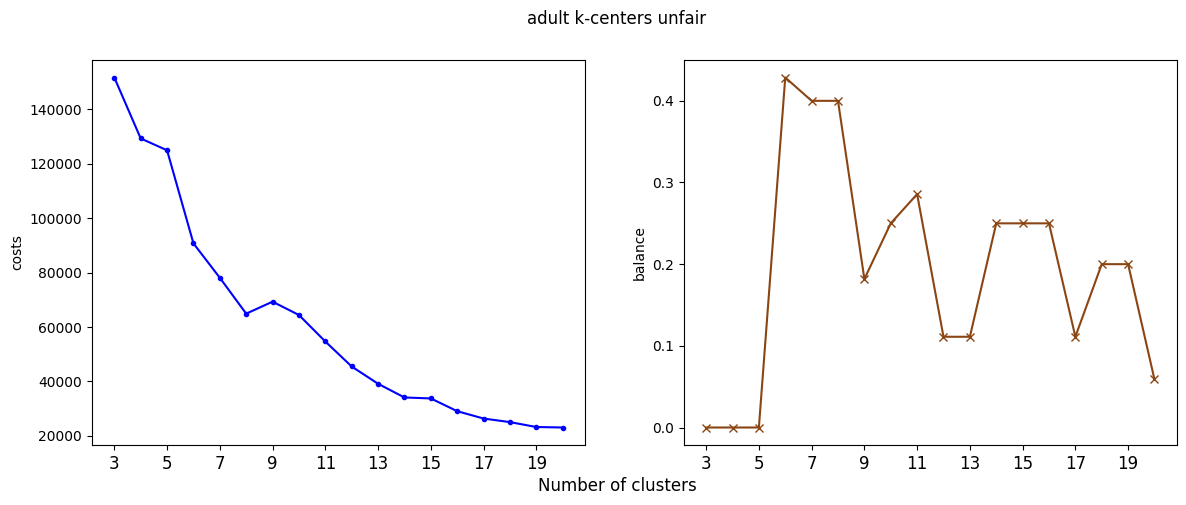

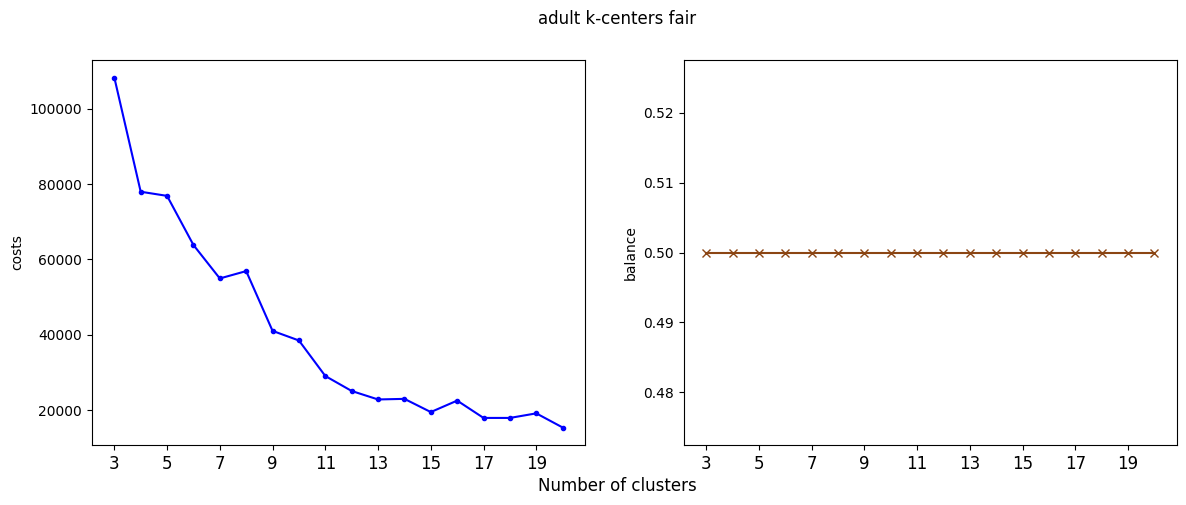

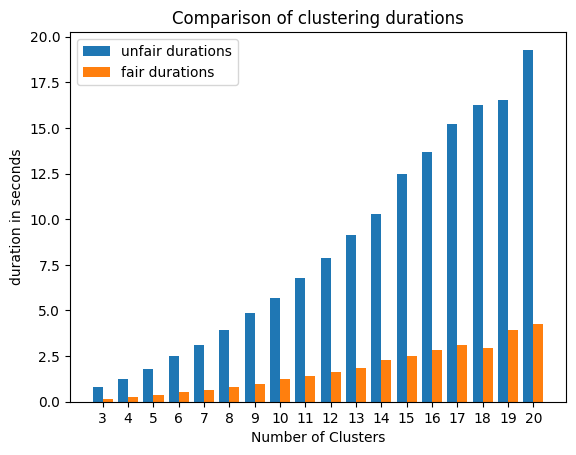

Dataset name: bank; randomState used: 44
Amount of single values:  12790
Amount of married values:  27214
Amount of 0 values:  339
Amount of 1 values:  661
balance of the chosen sample: 0.5128593040847201


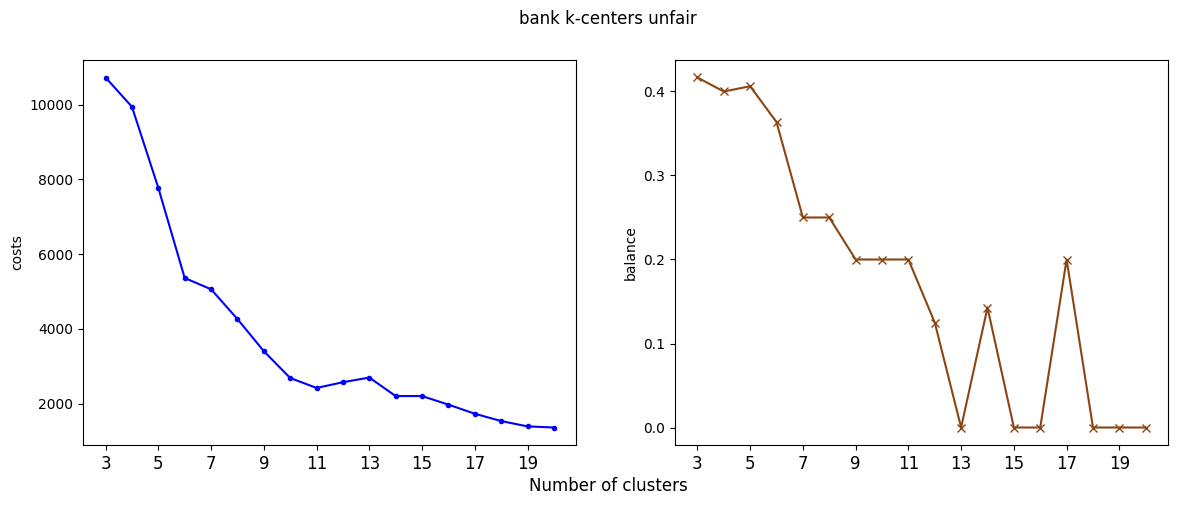

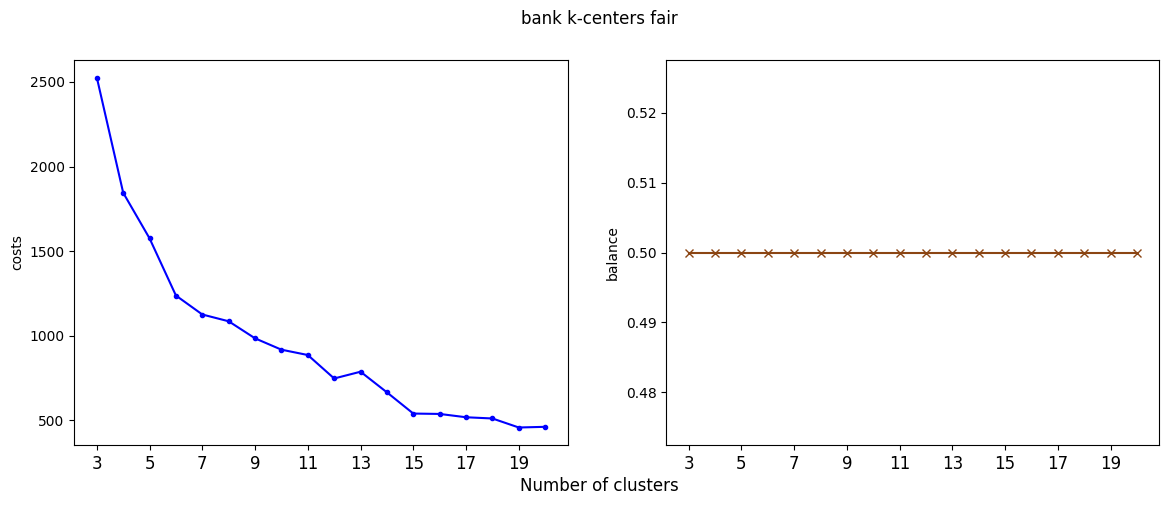

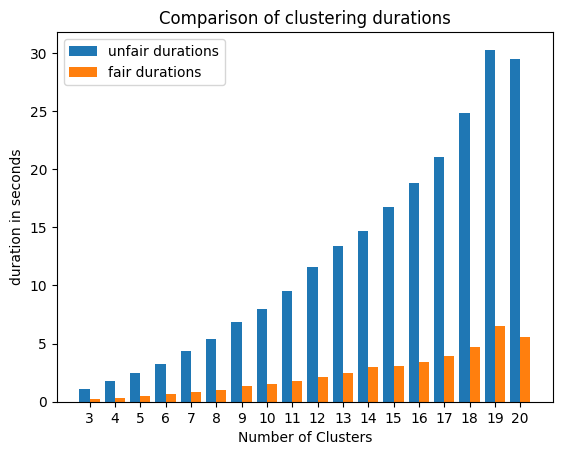

In [3]:
dataset_names = ["adult", "bank"]
clustering_methods = ["k-centers", "k-medians"]
clustering_method = clustering_methods[0]

for dataset_name in dataset_names:
    #load and sample data accorind to the paper
    X,_ = loader.load_dataset(dataset_name)
    #only return the columns of the protected attribute and the ones necessary for computing the distance
    prepared_dataset = loader.prepare_dataset(X, dataset_name)
    reds, blues = loader.red_blue_split(prepared_dataset, dataset_name)
    #take a sample with size according to the paper
    sample_balance = 0
    randomState = 42
    while(sample_balance < 0.5):
        sampled_dataset = loader.sample_data(prepared_dataset, dataset_name, randomState)
        sample_balance = mathHelper.get_balance(sampled_dataset, config[dataset_name]['sensitive_column'], dataset_name)
        randomState += 1

    sampled_reds, sampled_blues = loader.red_blue_split(sampled_dataset, dataset_name)

    print("Dataset name: %s; randomState used: %d" %(dataset_name,randomState-1))
    #some information about the dataset
    for sensitive_value in config[dataset_name]['sensitive_values']:
        print("Amount of %s values:  %d" %(sensitive_value, X.value_counts(config[dataset_name]['sensitive_column'])[sensitive_value]))

    #some information about the sample
    for sensitive_value in [0,1]:
        print("Amount of %s values:  %d" %(sensitive_value, sampled_dataset.value_counts(config[dataset_name]['sensitive_column'])[sensitive_value]))

    #output some information about the chosen sample
    sample_balance = mathHelper.get_balance(sampled_dataset, config[dataset_name]['sensitive_column'], dataset_name)
    print("balance of the chosen sample: " + str(sample_balance))

    fairletDecomposition = fairlet_decomposition(sampled_dataset, sampled_blues, sampled_reds, dataset_name, loader)
    fairletDecomposition.get_cluster_information(clustering_method=clustering_method, t=2, T=400)
    k_centers_instance = k_center.k_center(dataset_name, loader)
    cluster_counts, unfair_costs, unfair_balances, unfair_durations, fair_costs, fair_balances, fair_durations = fairletDecomposition.CalculateClusterCostAndBalance_K_Centers(k_centers_instance, 3, 20)

    plotHelper = plot_helper.plotHelper()
    base_title = dataset_name + " " + clustering_method
    plotHelper.plot_k_centers(cluster_counts, unfair_balances, unfair_costs, 2, ["K-Centers Costs", "K-Centers balance"], base_title + " unfair")
    plotHelper.plot_k_centers(cluster_counts, fair_balances, fair_costs, 2, ["K-Centers Costs", "K-Centers balance"], base_title + " fair")
    plotHelper.plot_durations(cluster_counts, unfair_durations, fair_durations)

In [4]:
#k-medians
X,_ = loader.load_dataset(dataset_name)
#only return the columns of the protected attribute and the ones necessary for computing the distance
prepared_dataset = loader.prepare_dataset(X, dataset_name)
reds, blues = loader.red_blue_split(prepared_dataset, dataset_name)
sampled_dataset = loader.sample_data(prepared_dataset, dataset_name, 42)

sampled_reds, sampled_blues = loader.red_blue_split(sampled_dataset, dataset_name)



In [52]:
n_clusters = 5
cluster_assignment = np.zeros(len(sampled_dataset))
maxRounds = 100
#TODO empty array of length n_clusters
costs = [None] * n_clusters

medians = sampled_dataset.sample(n=n_clusters)
#for i in range(maxRounds):

medians_t = medians.copy()

#assign points to clusters
for j in range(len(sampled_dataset)):
    distances = []
    for _, median in medians.iterrows():
        distances.append(mathHelper.compute_distance(sampled_dataset.iloc[j], median, dataset_name))
    idx = np.argmin(distances)
    val = np.min(distances)
    cluster_assignment[j] = idx

    #update cluster centers
for j in range(n_clusters):
    cluster_element_locs = [idx for idx, n in enumerate(cluster_assignment) if n == j]
    bla = sampled_dataset.iloc[cluster_element_locs]

    if len(bla > 0):
        medians.iloc[j] = bla.median()
    cost = sum(mathHelper.compute_distance(elem, medians.iloc[j], dataset_name) for _, elem in bla.iterrows())
    costs[j] = cost

    #stop condition
    #stop = np.sum(np.sum(np.power()))

medians

,marital,age,balance,duration
41842,1,33,64.0,843.5
44382,1,38,0.0,202.0
10709,1,39,388.5,117.0
26044,1,39,718.5,998.5
16787,1,42,2303.0,191.0


In [176]:
G_k_medians = create_MCF(distances, "k-medians")
flowCost, flowDictionary = nx.network_simplex(G_k_medians)
information, centers, costs = get_fairlet_information(flowDictionary)
fairlet_center_sampled_dataset = get_fairlet_center_dataframe(centers)
fairlet_centers_dataset = get_fairlet_center_dataframe(centers, False)


fairlet_center_sampled_dataset = get_fairlet_center_dataframe(centers)

n_clusters = 5
#vanilla
medians = sampled_dataset.to_numpy()[np.random.choice(range(0, sampled_dataset.shape[0]), size=n_clusters, replace=False)]
kmedians_vanilla = kmedians(sampled_dataset, medians)
kmedians_vanilla.process()
vanilla_clusters = kmedians_vanilla.get_clusters()



#fair
fairlet_medians = fairlet_center_sampled_dataset.to_numpy()[np.random.choice(range(0, fairlet_center_sampled_dataset.shape[0]), size=n_clusters, replace=False)]
kmedians_fairlets = kmedians(fairlet_center_sampled_dataset, fairlet_medians)
kmedians_fairlets.process()
fairlet_clusters = kmedians_fairlets.get_clusters()

kmedians_fairlets.get_cluster_encoding()

<type_encoding.CLUSTER_INDEX_LIST_SEPARATION: 1>